In [135]:
from collections.abc import Sequence
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate
from scipy.spatial.transform import Rotation
import vedo

from histalign.backend.ccf.paths import get_atlas_path
from histalign.backend.io import load_volume
from histalign.backend.maths import compute_centre, compute_normal_from_raw
from histalign.backend.models import (
    Orientation,
    Resolution,
)
from histalign.backend.models.errors import InvalidOrientationError

vedo.settings.default_backend = "vtk"

In [136]:
def imshow(image: np.ndarray) -> None:
    _ = plt.figure()

    plt.imshow(image)
    plt.axis(False)

    plt.show()


def show(meshes: vedo.CommonVisual | list[vedo.CommonVisual]) -> None:
    plotter = vedo.Plotter(axes=4)

    if not isinstance(meshes, list):
        meshes = [meshes]

    for mesh in meshes:
        plotter += mesh

    plotter.show(interactive=False).interactive().close()


def compute_origin_from_raw(
    centre: Sequence[int], offset: int, orientation: Orientation
) -> np.ndarray:
    if len(centre) != 3:
        raise ValueError(f"Centre should be 3 coordinates. Got {len(centre)}.")

    match orientation:
        case Orientation.CORONAL:
            origin = [centre[0] + offset, centre[1], centre[2]]
        case Orientation.HORIZONTAL:
            origin = [centre[0], centre[1] + offset, centre[2]]
        case Orientation.SAGITTAL:
            origin = [centre[0], centre[1], centre[2] + offset]
        case other:
            raise InvalidOrientationError(other)

    return np.array(origin)


def cut_with_planes(plane, origins, normals):
    shape = plane.metadata["shape"]

    plane.cut_with_planes(origins=origins[::2], normals=normals[::2], invert=True)

    shape[1] = len(plane.points) / shape[0]

    plane.cut_with_planes(origins=origins[1::2], normals=normals[1::2], invert=True)

    shape[0] = len(plane.points) / shape[1]
    plane.metadata["shape"] = shape

In [137]:
volume = load_volume(get_atlas_path(Resolution.MICRONS_100))

orientation = Orientation.CORONAL
offset = 10
pitch = 20
yaw = 30

origin = compute_origin_from_raw(
    compute_centre(volume.tonumpy().shape), offset, orientation
)
normal = compute_normal_from_raw(pitch, yaw, orientation).tolist()

slice_plane_mesh = volume.slice_plane(origin=origin, normal=normal, autocrop=False)

display_plane = vedo.Plane(
    origin,
    compute_normal_from_raw(0, 0, orientation),
    s=(max(volume.tonumpy().shape),) * 2,
)

display_plane.rotate(pitch, axis=[0, 0, 1], point=origin)
display_plane.rotate(
    yaw,
    axis=Rotation.from_euler("z", pitch, degrees=True).apply([0, 1, 0]),
    point=origin,
)
display_plane.rotate(
    -pitch,
    axis=Rotation.from_euler("ZY", [pitch, yaw], degrees=True).apply([1, 0, 0]),
    point=origin,
)

normal1 = display_plane.points[0] - display_plane.points[1]
normal2 = display_plane.points[1] - display_plane.points[3]
normal3 = display_plane.points[3] - display_plane.points[2]
normal4 = display_plane.points[2] - display_plane.points[0]

In [138]:
new_plane = slice_plane_mesh.copy()

start_time = perf_counter()
cut_with_planes(
    new_plane,
    [
        origin + normal1 * 0.5,
        origin + normal2 * 0.5,
        origin + normal3 * 0.5,
        origin + normal4 * 0.5,
    ],
    [normal1, normal2, normal3, normal4],
)
print(f"Cutting planes: {perf_counter() - start_time:.2f} seconds.")

Cutting planes: 0.03 seconds.


In [139]:
print(f"Original plane shape:  {slice_plane_mesh.metadata['shape']}")
print(f"Target plane shape:    {[max(volume.tonumpy().shape)] * 2}")
print(f"New plane shape:       {new_plane.metadata['shape']}")

Original plane shape:  [163 174]
Target plane shape:    [132, 132]
New plane shape:       [134 134]


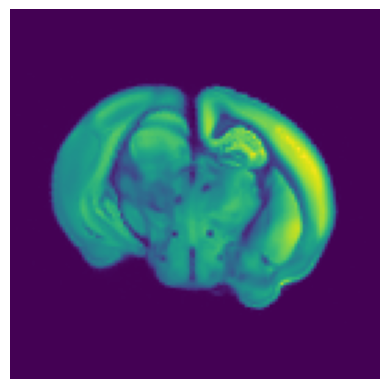

In [140]:
new_plane_array = new_plane.pointdata["ImageScalars"].reshape(
    new_plane.metadata["shape"]
)
new_plane_array = rotate(new_plane_array, pitch, reshape=False)
imshow(new_plane_array)